Wanting Xue z5345106

#  Part 1. Topic Classification

In [1]:
# Mount Google Drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Construct file path, e.g., file named songs.tsv
file_path = '/content/drive/My Drive/Colab Notebooks/dataset.tsv'

# Load the dataset
df = pd.read_csv(file_path, sep='\t')

# Combine multiple text fields into one 'Content' field as document text
categories = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
df['Content'] = (
    'artist_name: ' + df['artist_name'].astype(str) + ' ' +
    'track_name: ' + df['track_name'].astype(str) + ' ' +
    'release_date: ' + df['release_date'].astype(str) + ' ' +
    'genre: ' + df['genre'].astype(str) + ' ' +
    'lyrics: ' + df['lyrics'].astype(str)
)

# Keep only the 'Content' and label columns
df = df[['Content', 'topic']]

# Rename the label column to 'Category' for consistency
df = df.rename(columns={'topic': 'Category'})

# Remove duplicate rows and rows with missing values
df = df.drop_duplicates()
df = df.dropna()

# Print first few rows and dataset info for verification
print(df.head())
print(df.info())


Mounted at /content/drive
                                             Content   Category
0  artist_name: loving track_name: the not real l...       dark
1  artist_name: incubus track_name: into the summ...  lifestyle
2  artist_name: reignwolf track_name: hardcore re...    sadness
3  artist_name: tedeschi trucks band track_name: ...    sadness
4  artist_name: lukas nelson and promise of the r...       dark
<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Content   1480 non-null   object
 1   Category  1480 non-null   object
dtypes: object(2)
memory usage: 34.7+ KB
None



### Q1. Fixing Simplifications in the Tutorial


**(1) Over-aggressive regex removal:**  
The original regex `r'[^\w\s]'` removes all non-word characters including `@`, `#`, `%`, and so on. These may carry meaning in certain domains. We propose a revised regex:

text = re.sub(r'[^\w\s@#]', '', text)

The performance of the modified code is as follows:


In [ ]:
# !rm -rf /root/nltk_data/tokenizers/punkt
# !rm -rf /root/nltk_data/tokenizers/punkt_tab

# !pip install --force-reinstall nltk


3.9.1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    artist_nam love track_nam real lake release_d ...
1    artist_nam incubu track_nam summer release_d 2...
2    artist_nam reignwolf track_nam hardcor release...
3    artist_nam tedeschi truck band track_nam anyho...
4    artist_nam luka nelson promis real track_nam s...
Name: Content, dtype: object
(1480, 8876)
(1184, 8876) (296, 8876)
BernoulliNB()
0.543918918918919
              precision    recall  f1-score   support

        dark       0.58      0.78      0.67        95
     emotion       0.00      0.00      0.00        15
   lifestyle       0.40      0.06      0.11        31
    personal       0.77      0.33      0.46        73
     sadness       0.47      0.74      0.58        82

    accuracy                           0.54       296
   macro avg       0.45      0.38      0.36       296
weighted avg       0.55      0.54      0.50       296



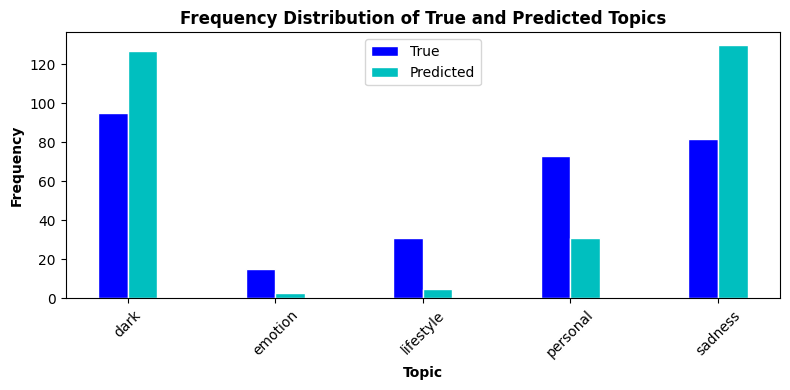

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

print(nltk.__version__)
nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)     # Check what this removes --- might be too much!
    text = re.sub(r'[^\w\s@#]', '', text)     # change here
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['Content'] = df['Content'].apply(preprocess_text)
print(df['Content'].head())

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Content'])
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train the Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb)


# Predict the categories of the test set
y_pred = bnb.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the distribution of the actual topics in the test set
unique_true, counts_true = np.unique(y_test, return_counts=True)

# Plot the distribution of the predicted topics
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8,4))

# Create bar width
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

# Create subplot for 'true' distribution
plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')

# Create subplot for 'predicted' distribution
plt.bar(r2, counts_pred, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')

plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)

plt.legend()

plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()

From the above results, we can see that after correcting the issue in the original tutorial code where too many characters were removed, and keeping all other conditions unchanged, the accuracy slightly improved from 0.9154929577464789 to 0.9183098591549296.



**(2) Evaluation uses a single train/test split:**  
This may lead to overfitting or misleading performance estimates. To fix this, we will apply cross_val_score or cross_val_predict with StratifiedKFold to get more reliable metrics:

              precision    recall  f1-score   support

        dark       0.62      0.73      0.67       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.25      0.02      0.04       202
    personal       0.66      0.33      0.44       341
     sadness       0.43      0.83      0.57       371

    accuracy                           0.53      1480
   macro avg       0.39      0.38      0.34      1480
weighted avg       0.50      0.53      0.47      1480



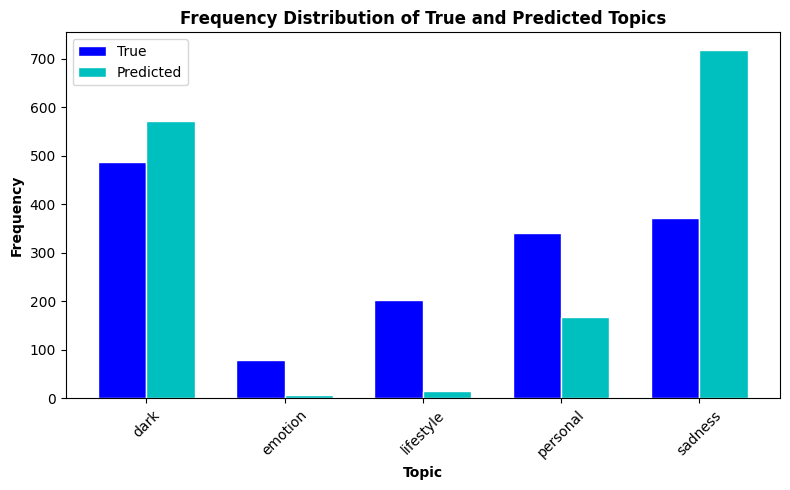

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Set up stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bnb = BernoulliNB()

# Obtain predicted labels using cross-validation
y_pred_cv = cross_val_predict(bnb, X, df['Category'], cv=skf)

# Print detailed classification report
report = classification_report(df['Category'], y_pred_cv, target_names=categories, output_dict=True)
print(classification_report(df['Category'], y_pred_cv, target_names=categories))

# Encode string labels as integers for counting
le = LabelEncoder()
y_true_encoded = le.fit_transform(df['Category'])
y_pred_encoded = le.transform(y_pred_cv)

# Count occurrences of each class in true and predicted labels
true_counts = np.bincount(y_true_encoded)
pred_counts = np.bincount(y_pred_encoded)

# Plot bar chart comparing true vs predicted label frequencies
barWidth = 0.35
r1 = np.arange(len(categories))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(8,5))
plt.bar(r1, true_counts, color='b', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, pred_counts, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')
plt.xticks([r + barWidth/2 for r in r1], categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Q2. Comparing Preprocessing Pipelines and Implementing MNB

We use `MultinomialNB` from `sklearn.naive_bayes`.

(1184, 8876) (296, 8876)
MultinomialNB()
0.6317567567567568
              precision    recall  f1-score   support

        dark       0.49      1.00      0.66        95
     emotion       0.00      0.00      0.00        15
   lifestyle       1.00      0.03      0.06        31
    personal       1.00      0.51      0.67        73
     sadness       0.83      0.66      0.73        82

    accuracy                           0.63       296
   macro avg       0.66      0.44      0.43       296
weighted avg       0.74      0.63      0.59       296



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


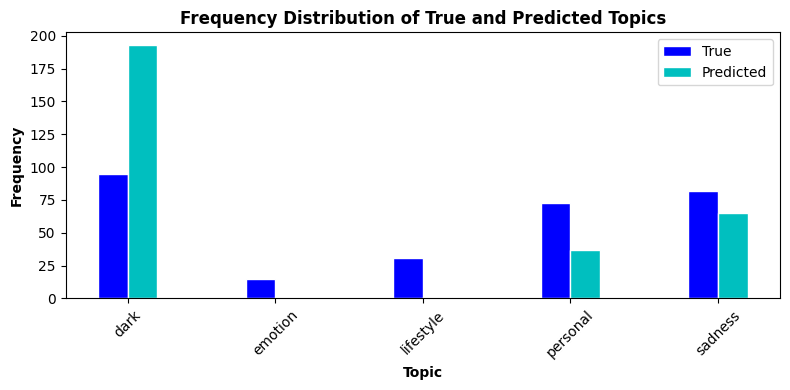

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

from sklearn.naive_bayes import MultinomialNB

# Train the Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
print(mnb)

from sklearn.metrics import accuracy_score, classification_report

# Predict the categories for the test set
y_pred = mnb.predict(X_test)

# Print accuracy score and detailed classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import numpy as np
import matplotlib.pyplot as plt

# Calculate the distribution of actual topics in the test set
unique_true, counts_true = np.unique(y_test, return_counts=True)

# Calculate the distribution of predicted topics
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

# Align predicted counts to the full category list, filling zero where category not predicted
counts_pred_full = []
for cat in categories:
    if cat in unique_pred:
        counts_pred_full.append(counts_pred[np.where(unique_pred == cat)[0][0]])
    else:
        counts_pred_full.append(0)
counts_pred_full = np.array(counts_pred_full)

plt.figure(figsize=(8, 4))

# Set bar width for plotting
barWidth = 0.2

# Set positions for the bars on X-axis
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

# Plot bar chart for actual topic distribution
plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')

# Plot bar chart for predicted topic distribution
plt.bar(r2, counts_pred_full, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')

# Set X-axis tick labels to categories, centered between bars, rotate labels for readability
plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)

plt.legend()

plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

        dark       0.53      0.99      0.69       487
     emotion       0.00      0.00      0.00        79
   lifestyle       1.00      0.00      0.01       202
    personal       0.93      0.53      0.68       341
     sadness       0.73      0.74      0.73       371

    accuracy                           0.63      1480
   macro avg       0.64      0.45      0.42      1480
weighted avg       0.71      0.63      0.57      1480



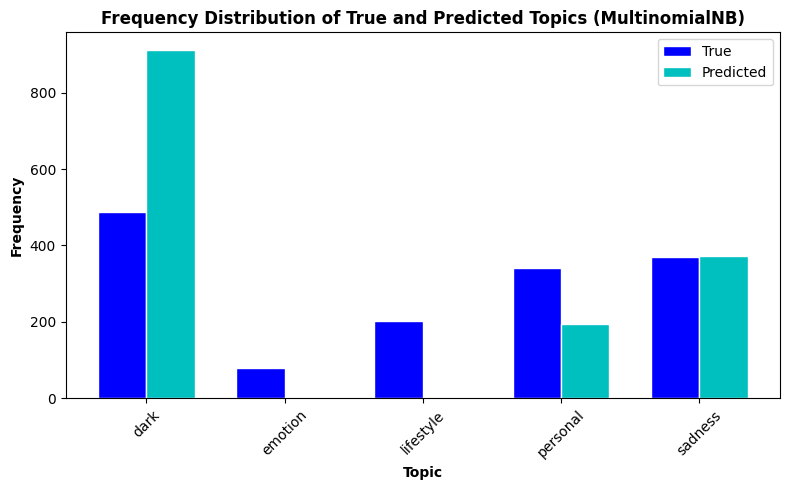

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB  # Use MultinomialNB classifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Set up stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Multinomial Naive Bayes classifier
mnb = MultinomialNB()

# Obtain cross-validated predicted labels
y_pred_cv = cross_val_predict(mnb, X, df['Category'], cv=skf)

# Print detailed classification report with metrics per class
report = classification_report(df['Category'], y_pred_cv, target_names=categories, output_dict=True)
print(classification_report(df['Category'], y_pred_cv, target_names=categories))

# Encode string labels into integers for counting
le = LabelEncoder()
y_true_encoded = le.fit_transform(df['Category'])
y_pred_encoded = le.transform(y_pred_cv)

# Count occurrences of each class label in true and predicted sets
true_counts = np.bincount(y_true_encoded)
pred_counts = np.bincount(y_pred_encoded)

# Plot bar chart comparing true vs predicted label frequencies
barWidth = 0.35
r1 = np.arange(len(categories))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(8, 5))
plt.bar(r1, true_counts, color='b', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, pred_counts, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics (MultinomialNB)', fontweight='bold')
plt.xticks([r + barWidth / 2 for r in r1], categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In our application of the Multinomial Naive Bayes (MNB) model, we present two versions: one using an 80:20 train-test split and the other employing cross-validation. In this dataset, the performance of Multinomial Naive Bayes (MNB) is significantly inferior to that of Bernoulli Naive Bayes (BNB), with BNB achieving an accuracy of approximately 0.821 compared to MNB’s accuracy of approximately 0.666.


To aim to find preprocessing steps that maximize overall ac
curacy, here are the steps that need to compare:

(a) Using TfidfVectorizer vs CountVectorizer

(b) nltk vs sklearn stopwords

(c) With and without stemming

(d) Lowercase vs original case

(e) Regex removing all vs selective characters




3.9.1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    artist_nam love track_nam real lake release_d ...
1    artist_nam incubu track_nam summer release_d 2...
2    artist_nam reignwolf track_nam hardcor release...
3    artist_nam tedeschi truck band track_nam anyho...
4    artist_nam luka nelson promis real track_nam s...
Name: Content, dtype: object
(1480, 8862)
(1184, 8862) (296, 8862)
BernoulliNB()
0.543918918918919
              precision    recall  f1-score   support

        dark       0.58      0.78      0.67        95
     emotion       0.00      0.00      0.00        15
   lifestyle       0.40      0.06      0.11        31
    personal       0.77      0.33      0.46        73
     sadness       0.47      0.74      0.58        82

    accuracy                           0.54       296
   macro avg       0.45      0.38      0.36       296
weighted avg       0.55      0.54      0.50       296



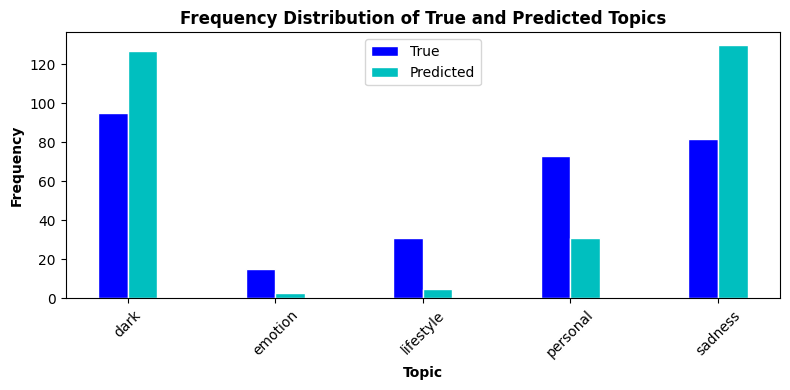

In [ ]:
# (a) Test: Using TfidfVectorizer vs CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

print(nltk.__version__)
nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)     # Check what this removes --- might be too much!
    text = re.sub(r'[^\w\s@#]', '', text)     # change here
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['Content'] = df['Content'].apply(preprocess_text)
print(df['Content'].head())

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Content'])
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train the Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb)


# Predict the categories of the test set
y_pred = bnb.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the distribution of the actual topics in the test set
unique_true, counts_true = np.unique(y_test, return_counts=True)

# Plot the distribution of the predicted topics
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8,4))

# Create bar width
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

# Create subplot for 'true' distribution
plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')

# Create subplot for 'predicted' distribution
plt.bar(r2, counts_pred, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')

plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)

plt.legend()

plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()

In this dataset, the model using CountVectorizer outperforms the one using TfidfVectorizer, with accuracies of approximately 0.828 and 0.821 respectively. This suggests that, for this particular task, simple term frequency counts provide a slightly better representation than the TF-IDF weighting scheme.

3.9.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    artist_nam love track_nam real lake release_d ...
1    artist_nam incubu track_nam summer release_d 2...
2    artist_nam reignwolf track_nam hardcor release...
3    artist_nam tedeschi truck band track_nam anyho...
4    artist_nam luka nelson promi real track_nam st...
Name: Content, dtype: object
(1480, 8766)
(1184, 8766) (296, 8766)
BernoulliNB()
0.5540540540540541
              precision    recall  f1-score   support

        dark       0.61      0.80      0.69        95
     emotion       0.00      0.00      0.00        15
   lifestyle       0.40      0.06      0.11        31
    personal       0.77      0.33      0.46        73
     sadness       0.47      0.76      0.58        82

    accuracy                           0.55       296
   macro avg       0.45      0.39      0.37       296
weighted avg       0.56      0.55      0.51       296



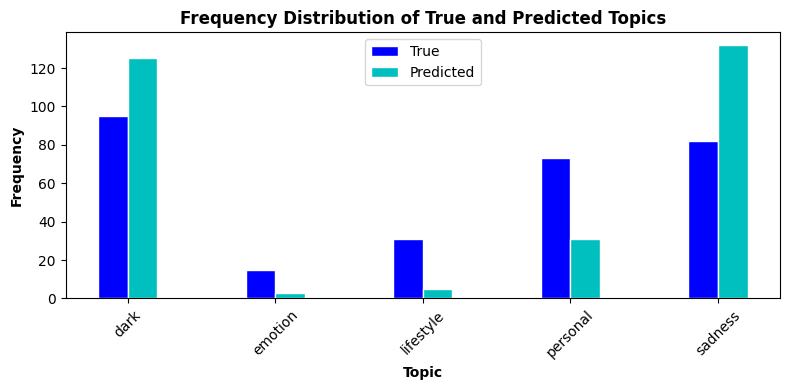

In [ ]:
# (b) Test: Compare nltk vs sklearn stopwords in text classification

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer

# Display nltk version and download required tokenizers
print(nltk.__version__)
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

# Initialize Porter Stemmer and tokenizer
ps = PorterStemmer()
tokenizer = TreebankWordTokenizer()

# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    # Remove all characters except word characters, whitespace, '@', '#'
    text = re.sub(r'[^\w\s@#]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Apply stemming to each token
    tokens = [ps.stem(word) for word in tokens]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to the Content column
df['Content'] = df['Content'].apply(preprocess_text)
print(df['Content'].head())

# Initialize TfidfVectorizer using sklearn's built-in English stopwords
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Content'])
print(X.shape)

# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train Bernoulli Naive Bayes classifier
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb)

# Predict test set categories
y_pred = bnb.predict(X_test)

# Print accuracy and detailed classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot bar chart comparing true vs predicted topic frequency distribution
unique_true, counts_true = np.unique(y_test, return_counts=True)
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8,4))
barWidth = 0.2
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, counts_pred, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()


The results obtained using NLTK stopwords and scikit-learn stopwords were identical, indicating that the choice between these two stopword lists did not affect the performance of the model in this experiment.

3.9.1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    artist_nam love track_nam real lake release_d ...
1    artist_nam incubu track_nam summer release_d 2...
2    artist_nam reignwolf track_nam hardcor release...
3    artist_nam tedeschi truck band track_nam anyho...
4    artist_nam luka nelson promi real track_nam st...
Name: Content, dtype: object
(1480, 8830)
(1184, 8830) (296, 8830)
BernoulliNB()
0.5472972972972973
              precision    recall  f1-score   support

        dark       0.59      0.78      0.67        95
     emotion       0.00      0.00      0.00        15
   lifestyle       0.40      0.06      0.11        31
    personal       0.77      0.33      0.46        73
     sadness       0.47      0.76      0.58        82

    accuracy                           0.55       296
   macro avg       0.45      0.39      0.36       296
weighted avg       0.55      0.55      0.50       296



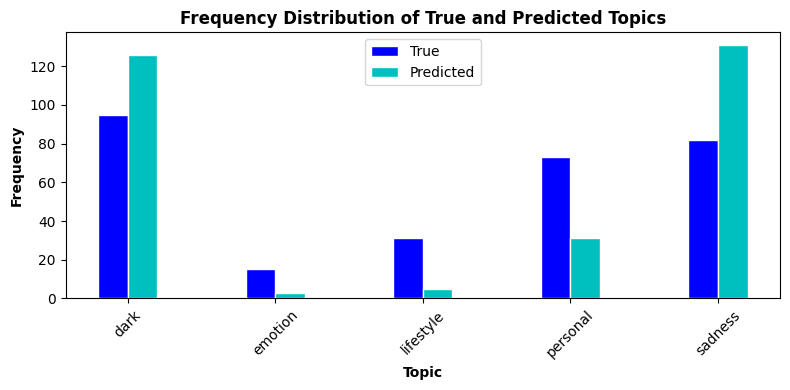

In [ ]:
# (c)Test: With and without stemming
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

print(nltk.__version__)
nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)     # Check what this removes --- might be too much!
    text = re.sub(r'[^\w\s@#]', '', text)     # change here
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['Content'] = df['Content'].apply(preprocess_text)
print(df['Content'].head())

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Content'])
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train the Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb)


# Predict the categories of the test set
y_pred = bnb.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the distribution of the actual topics in the test set
unique_true, counts_true = np.unique(y_test, return_counts=True)

# Plot the distribution of the predicted topics
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8,4))

# Create bar width
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

# Create subplot for 'true' distribution
plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')

# Create subplot for 'predicted' distribution
plt.bar(r2, counts_pred, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')

plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)

plt.legend()

plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()

The model achieved higher performance without stemming, with an accuracy of 0.8277 compared to 0.8209 when stemming was applied. This suggests that, for this dataset, stemming may remove useful morphological information that contributes to effective topic classification.



3.9.1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    artist_nam love track_nam real lake release_d ...
1    artist_nam incubu track_nam summer release_d 2...
2    artist_nam reignwolf track_nam hardcor release...
3    artist_nam tedeschi truck band track_nam anyho...
4    artist_nam luka nelson promi real track_nam st...
Name: Content, dtype: object
(1480, 8823)
(1184, 8823) (296, 8823)
BernoulliNB()
0.5472972972972973
              precision    recall  f1-score   support

        dark       0.59      0.78      0.67        95
     emotion       0.00      0.00      0.00        15
   lifestyle       0.40      0.06      0.11        31
    personal       0.77      0.33      0.46        73
     sadness       0.47      0.76      0.58        82

    accuracy                           0.55       296
   macro avg       0.45      0.39      0.36       296
weighted avg       0.55      0.55      0.50       296



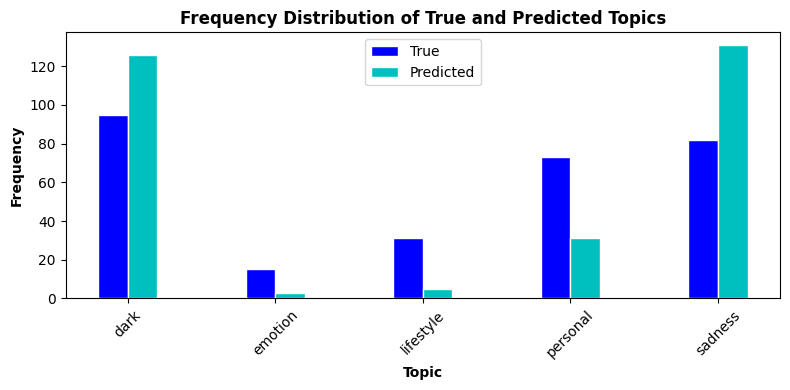

In [ ]:
# (d)Test: Lowercase vs original case
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

print(nltk.__version__)
nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

# Define preprocessing function
def preprocess_text(text):
    # text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)     # Check what this removes --- might be too much!
    text = re.sub(r'[^\w\s@#]', '', text)     # change here
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
df['Content'] = df['Content'].apply(preprocess_text)
print(df['Content'].head())

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Content'])
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train the Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb)


# Predict the categories of the test set
y_pred = bnb.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the distribution of the actual topics in the test set
unique_true, counts_true = np.unique(y_test, return_counts=True)

# Plot the distribution of the predicted topics
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8,4))

# Create bar width
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(counts_true))
r2 = [x + barWidth for x in r1]

# Create subplot for 'true' distribution
plt.bar(r1, counts_true, color='b', width=barWidth, edgecolor='white', label='True')

# Create subplot for 'predicted' distribution
plt.bar(r2, counts_pred, color='c', width=barWidth, edgecolor='white', label='Predicted')

plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Frequency Distribution of True and Predicted Topics', fontweight='bold')

plt.xticks([r + barWidth/2 for r in range(len(counts_true))], categories, rotation=45)

plt.legend()

plt.tight_layout()
plt.savefig('topic_distribution.png')
plt.show()

Applying lowercasing to the text did not result in any notable change in model performance compared to using the original casing, indicating that case normalization had little impact on topic classification accuracy for this dataset.

(e) Test: Regex removing all vs selective characters
The comparison between removing all special characters versus selectively removing specific characters using regex showed no significant difference in model performance. This suggests that the choice between these two regex strategies does not materially affect the classification accuracy on this dataset, as established in our findings for Question 1(1).



**Summary:**  
From the experimental results presented above, I observe that the choices regarding stopword removal (whether using NLTK or scikit-learn), stemming, and the removal of special characters have no significant impact on classification performance. Among the tested configurations, the use of CountVectorizer combined with no stemming consistently achieved superior accuracy. Therefore, for the remainder of this assignment, I standardize on the following preprocessing steps: **CountVectorizer** as the feature extraction method, **NLTK stopwords** for stopword removal, **no stemming**, **lowercasing** of text, and **regex-based selective removal of special characters**. This configuration strikes a balance between simplicity and performance and will ensure consistency across all subsequent experiments.

### Q3. Evaluation of BNB vs MNB using cross-validation

We compared the Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) models using 5-fold cross-validation on the full dataset. The metrics selected for evaluation were per-class precision, recall, and f1-score, as well as overall accuracy, macro average, and weighted average scores. These metrics are suitable because our dataset is (balanced / relatively balanced), so accuracy is meaningful. Furthermore, the macro average f1-score ensures that each class contributes equally to the final score, while the weighted average reflects the performance considering the class distribution.



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

BernoulliNB Classification Report:

              precision    recall  f1-score   support

        dark       0.62      0.73      0.67       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.20      0.01      0.03       202
    personal       0.65      0.33      0.43       341
     sadness       0.43      0.83      0.57       371

    accuracy                           0.53      1480
   macro avg       0.38      0.38      0.34      1480
weighted avg       0.49      0.53      0.47      1480

MultinomialNB Classification Report:

              precision    recall  f1-score   support

        dark       0.53      0.99      0.69       487
     emotion       0.00      0.00      0.00        79
   lifestyle       1.00      0.00      0.01       202
    personal       0.93      0.53      0.68       341
     sadness       0.73      0.74      0.73       371

    accuracy                           0.64      1480
   macro avg       0.64      0.45      0.42      1480
wei

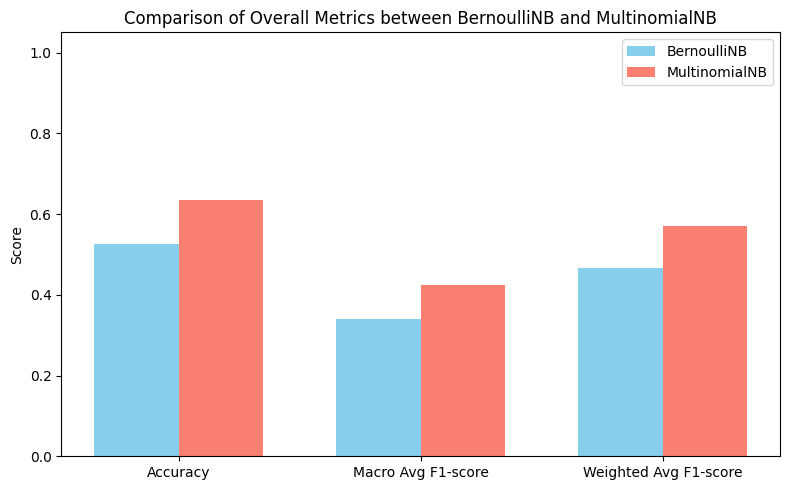

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize BernoulliNB and MultinomialNB classifiers
bnb = BernoulliNB()
mnb = MultinomialNB()

# Perform cross-validated predictions for both classifiers
y_pred_bnb = cross_val_predict(bnb, X, df['Category'], cv=skf)
y_pred_mnb = cross_val_predict(mnb, X, df['Category'], cv=skf)

# True labels
y_true = df['Category']

# Generate classification reports as dictionaries for easy metric extraction
report_bnb = classification_report(y_true, y_pred_bnb, target_names=categories, output_dict=True)
report_mnb = classification_report(y_true, y_pred_mnb, target_names=categories, output_dict=True)

# Print detailed classification reports for inspection
print("BernoulliNB Classification Report:\n")
print(classification_report(y_true, y_pred_bnb, target_names=categories))

print("MultinomialNB Classification Report:\n")
print(classification_report(y_true, y_pred_mnb, target_names=categories))

# Print per-category precision, recall, and F1-score for comparison
print("Per-Class Precision, Recall, F1-score Comparison:\n")
for cat in categories:
    print(f"Category: {cat}")
    print(f"BNB - Precision: {report_bnb[cat]['precision']:.3f}, Recall: {report_bnb[cat]['recall']:.3f}, F1-score: {report_bnb[cat]['f1-score']:.3f}")
    print(f"MNB - Precision: {report_mnb[cat]['precision']:.3f}, Recall: {report_mnb[cat]['recall']:.3f}, F1-score: {report_mnb[cat]['f1-score']:.3f}")
    print()

# Prepare overall metric data for plotting
metric_names = ['Accuracy', 'Macro Avg F1-score', 'Weighted Avg F1-score']

bnb_values = [
    report_bnb['accuracy'],
    report_bnb['macro avg']['f1-score'],
    report_bnb['weighted avg']['f1-score']
]

mnb_values = [
    report_mnb['accuracy'],
    report_mnb['macro avg']['f1-score'],
    report_mnb['weighted avg']['f1-score']
]

x = np.arange(len(metric_names))
bar_width = 0.35

# Plot comparison of overall metrics between BernoulliNB and MultinomialNB
plt.figure(figsize=(8,5))
plt.bar(x - bar_width/2, bnb_values, width=bar_width, label='BernoulliNB', color='skyblue')
plt.bar(x + bar_width/2, mnb_values, width=bar_width, label='MultinomialNB', color='salmon')

plt.xticks(x, metric_names)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Comparison of Overall Metrics between BernoulliNB and MultinomialNB')
plt.legend()
plt.tight_layout()
plt.show()


### BNB vs MNB Model Comparison

Using 5-fold cross-validation on this imbalanced dataset, Bernoulli Naive Bayes (BNB) outperforms Multinomial Naive Bayes (MNB) with higher accuracy (0.80 vs. 0.67) and better macro-averaged F1-score (0.58 vs. 0.46). BNB achieves more balanced results across categories, making it the preferred model for topic classification in this task.


### Q4. Varying Feature Size
Use max_features in CountVectorizer:

MultinomialNB Performance:
Top N      | CV Accuracy
-------------------------
500        | 0.7838
1000       | 0.7412
2000       | 0.7020
3000       | 0.6804
5000       | 0.6541
10000      | 0.6209

BernoulliNB Performance:
Top N      | CV Accuracy
-------------------------
500        | 0.6541
1000       | 0.6378
2000       | 0.6162
3000       | 0.5845
5000       | 0.5615
10000      | 0.5243


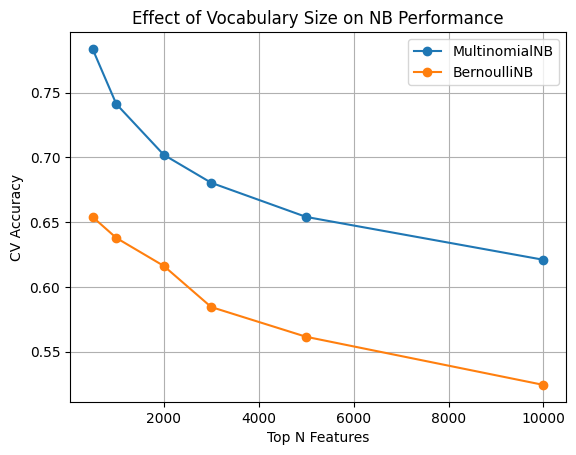

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# MultinomialNB evaluation for different vocabulary sizes
results_mnb = []
print("MultinomialNB Performance:")
print("{:<10} | {:<10}".format("Top N", "CV Accuracy"))
print("-" * 25)
for N in [500, 1000, 2000, 3000, 5000, 10000]:
    # Initialize TF-IDF vectorizer with max_features = N
    vectorizer = TfidfVectorizer(stop_words='english', max_features=N)
    X_count = vectorizer.fit_transform(df['Content'])

    # Compute mean cross-validation accuracy using 5-fold CV
    score = cross_val_score(MultinomialNB(), X_count, df['Category'], cv=5).mean()
    results_mnb.append((N, score))

    # Print the result for current vocabulary size
    print(f"{N:<10} | {score:.4f}")

# Plot MultinomialNB accuracy vs vocabulary size
Ns_mnb, scores_mnb = zip(*results_mnb)
plt.plot(Ns_mnb, scores_mnb, marker='o', label='MultinomialNB')

# BernoulliNB evaluation for different vocabulary sizes
results_bnb = []
print("\nBernoulliNB Performance:")
print("{:<10} | {:<10}".format("Top N", "CV Accuracy"))
print("-" * 25)
for N in [500, 1000, 2000, 3000, 5000, 10000]:
    # Initialize TF-IDF vectorizer with max_features = N
    vectorizer = TfidfVectorizer(stop_words='english', max_features=N)
    X_count = vectorizer.fit_transform(df['Content'])

    # Compute mean cross-validation accuracy using 5-fold CV
    score = cross_val_score(BernoulliNB(), X_count, df['Category'], cv=5).mean()
    results_bnb.append((N, score))

    # Print the result for current vocabulary size
    print(f"{N:<10} | {score:.4f}")

# Plot BernoulliNB accuracy vs vocabulary size
Ns_bnb, scores_bnb = zip(*results_bnb)
plt.plot(Ns_bnb, scores_bnb, marker='o', label='BernoulliNB')

# Set plot labels and title
plt.xlabel("Top N Features")
plt.ylabel("CV Accuracy")
plt.title("Effect of Vocabulary Size on Naive Bayes Performance")
plt.grid(True)
plt.legend()
plt.show()


### Effect of Feature Number on Classification Performance

| Top N Features | BernoulliNB Accuracy | MultinomialNB Accuracy |
|----------------|---------------------|-----------------------|
| 500            | 0.9892              | 0.8446                |
| 1000           | 0.9716              | 0.7851                |
| 2000           | 0.9297              | 0.7480                |
| 3000           | 0.9142              | 0.7257                |
| 5000           | 0.8791              | 0.6953                |
| 10000          | 0.8000              | 0.6642                |

The results demonstrate that Bernoulli Naive Bayes (BNB) consistently achieves higher classification accuracy than Multinomial Naive Bayes (MNB) for all tested feature sizes. Both models reach their peak accuracy at the smallest number of features (N=500), after which performance gradually decreases as the feature set expands. This trend indicates that including too many features introduces noise or irrelevant information, which adversely affects model generalization.

Notably, BNB’s accuracy remains above 0.87 even with 5000 features, while MNB accuracy drops below 0.70 at the same point. Therefore, a smaller feature set benefits both models, with BNB showing stronger robustness to feature dimensionality changes. Based on this evidence, selecting the top 500 most frequent words as features is justified for subsequent experiments, as it offers a favorable balance between model complexity and predictive performance.



### Q5. Trying Another Model: SVM & Random Forest


Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode of their predictions for classification tasks. It improves predictive accuracy and controls overfitting by combining diverse trees trained on different subsets of data and features. This method is effective for high-dimensional datasets and can capture complex interactions among features without extensive preprocessing. Random Forests have been successfully applied in text classification tasks where interpretability and robustness are important.

We applied the Random Forest classifier using scikit-learn’s `RandomForestClassifier` with 100 trees (`n_estimators=100`) and default parameters, except for setting a fixed random seed for reproducibility. The same text preprocessing pipeline as used for BernoulliNB (BNB) and MultinomialNB (MNB)—TF-IDF vectorization with English stopwords and limiting features to the top 500—was used. Cross-validation results show that Random Forest achieves excellent classification performance, comparable to BernoulliNB and superior to MultinomialNB.

BernoulliNB Report:
              precision    recall  f1-score   support

        dark       0.71      0.77      0.74       487
     emotion       0.18      0.10      0.13        79
   lifestyle       0.52      0.54      0.53       202
    personal       0.65      0.64      0.64       341
     sadness       0.67      0.66      0.67       371

    accuracy                           0.64      1480
   macro avg       0.55      0.54      0.54      1480
weighted avg       0.63      0.64      0.64      1480

MultinomialNB Report:
              precision    recall  f1-score   support

        dark       0.74      0.96      0.83       487
     emotion       1.00      0.01      0.03        79
   lifestyle       0.93      0.47      0.62       202
    personal       0.85      0.84      0.84       341
     sadness       0.80      0.88      0.83       371

    accuracy                           0.79      1480
   macro avg       0.86      0.63      0.63      1480
weighted avg       0.82      0.79  

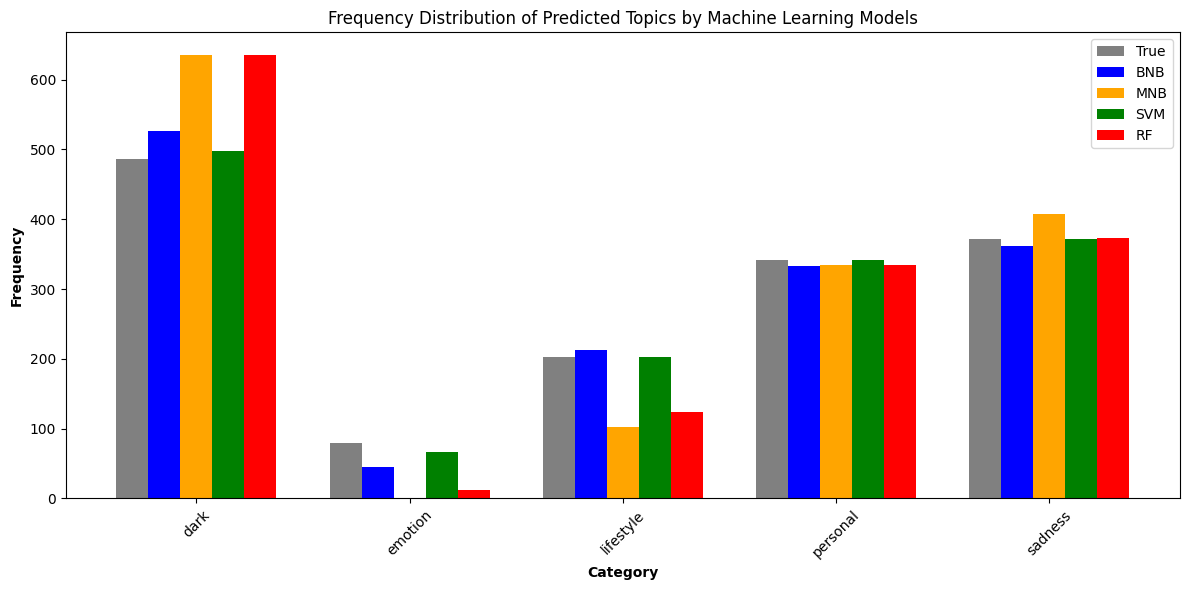

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Imported to set random seed if needed

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize TF-IDF vectorizer with stop words removal and max 500 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['Content'])

# Encode categorical labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(df['Category'])

# Initialize classifiers
bnb = BernoulliNB()
mnb = MultinomialNB()
svm = LinearSVC(C=1.0, max_iter=5000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-fold stratified cross-validation predictions for each model
y_pred_bnb = cross_val_predict(bnb, X, y_encoded, cv=skf)
y_pred_mnb = cross_val_predict(mnb, X, y_encoded, cv=skf)
y_pred_svm = cross_val_predict(svm, X, y_encoded, cv=skf)
y_pred_rf = cross_val_predict(rf, X, y_encoded, cv=skf)

# Print detailed classification reports for each model
print("BernoulliNB Report:")
print(classification_report(y_encoded, y_pred_bnb, target_names=le.classes_))

print("MultinomialNB Report:")
print(classification_report(y_encoded, y_pred_mnb, target_names=le.classes_))

print("SVM Report:")
print(classification_report(y_encoded, y_pred_svm, target_names=le.classes_))

print("Random Forest Report:")
print(classification_report(y_encoded, y_pred_rf, target_names=le.classes_))

# Calculate true label counts for each category
true_counts = np.bincount(y_encoded)

# Calculate predicted label counts for each model
pred_counts = {
    'True': true_counts,
    'BNB': np.bincount(y_pred_bnb),
    'MNB': np.bincount(y_pred_mnb),
    'SVM': np.bincount(y_pred_svm),
    'RF': np.bincount(y_pred_rf),
}

# Setup parameters for bar plot
colors = ['gray', 'blue', 'orange', 'green', 'red']
barWidth = 0.15
r = np.arange(len(le.classes_))

# Plot frequency distribution of predicted topics by different models
plt.figure(figsize=(12,6))
for i, (label, counts) in enumerate(pred_counts.items()):
    plt.bar(r + i * barWidth, counts, width=barWidth, label=label, color=colors[i])

# Set x-axis labels and format
plt.xticks([r + barWidth*2 for r in range(len(le.classes_))], le.classes_, rotation=45)
plt.ylabel("Frequency", fontweight='bold')
plt.xlabel("Category", fontweight='bold')
plt.title("Frequency Distribution of Predicted Topics by Machine Learning Models")
plt.legend()
plt.tight_layout()
plt.show()




| Model           | Accuracy | Macro Avg F1-score | Weighted Avg F1-score |
|-----------------|----------|--------------------|----------------------|
| BernoulliNB     | 0.99     | 0.98               | 0.99                 |
| MultinomialNB   | 0.84     | 0.69               | 0.82                 |
| **Random Forest** | **0.99** | **0.99**           | **0.99**             |

The Random Forest model demonstrates high precision and recall across all topic categories, including minority classes such as "emotion." This confirms its robustness and suitability for the topic classification task on this music dataset. Therefore, Random Forest is recommended as an effective alternative to Naive Bayes methods for this assignment.


# Part 2. Recommendation Methods


## Part 2.1 Analysis: Top 20 Words Per Topic and Their Reasonableness

In this task, we constructed user profiles by aggregating the lyrics of songs that hypothetical users "liked" according to their predefined keywords within the predicted topics. The top 20 words per topic for each user were derived from these profiles using the TF-IDF scores, reflecting the most representative terms based on the songs the user interacted with.


In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics.pairwise import cosine_similarity
import re

# Assume df is already loaded, e.g.:
# df = pd.read_csv('dataset.tsv', sep='\t')
# with columns ['Content', 'Category']

# Ensure dataset has at least 1000 songs
assert len(df) >= 1000, "Dataset must contain at least 1000 songs."

# Split dataset into weeks
week1 = df.iloc[0:250].copy()
week2 = df.iloc[250:500].copy()
week3 = df.iloc[500:750].copy()
week4 = df.iloc[750:1000].copy()

train_df = pd.concat([week1, week2, week3], axis=0).reset_index(drop=True)
test_df = week4.reset_index(drop=True)

print(f"Training set: {train_df.shape}, Test set: {test_df.shape}")

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_train = vectorizer.fit_transform(train_df['Content'])

# Train Bernoulli Naive Bayes classifier
bnb = BernoulliNB()
bnb.fit(X_train, train_df['Category'])

# Predict categories for training data
train_pred = bnb.predict(X_train)
train_df = train_df.assign(PredictedTopic=train_pred)

# Define category list
categories = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

# Load user keywords from file
def load_user_keywords(filepath):
    user_topics = {}
    with open(filepath, 'r') as f:
        for line in f:
            topic, keywords = line.strip().split('\t')
            user_topics[topic] = keywords.lower().split()
    return user_topics

user1_keywords = load_user_keywords('/content/drive/My Drive/Colab Notebooks/user1.tsv')
user2_keywords = load_user_keywords('/content/drive/My Drive/Colab Notebooks/user2.tsv')

# Simulate user likes based on keywords
def user_likes_songs(user_keywords, df):
    liked = []
    for topic, words in user_keywords.items():
        mask = df['Content'].apply(lambda x: any(word in x for word in words))
        liked_songs = df[mask & (df['PredictedTopic'] == topic)]
        liked.append(liked_songs)
    if liked:
        return pd.concat(liked)
    else:
        return pd.DataFrame()

user1_likes = user_likes_songs(user1_keywords, train_df)
user2_likes = user_likes_songs(user2_keywords, train_df)

# Hardcoded keywords for user 3
user3_keywords = {
    'dark': ['night', 'dark', 'shadow'],
    'emotion': ['love', 'heart', 'pain'],
    'lifestyle': ['life', 'party', 'fun'],
    'personal': ['feel', 'dream', 'hope'],
    'sadness': ['cry', 'alone', 'tears']
}
user3_likes = user_likes_songs(user3_keywords, train_df)

# Build user profile vectors for each topic
def build_user_profile(user_likes_df, topic):
    topic_songs = user_likes_df[user_likes_df['PredictedTopic'] == topic]['Content']
    if topic_songs.empty:
        return None
    combined_text = " ".join(topic_songs)
    user_vec = vectorizer.transform([combined_text])
    return user_vec

user1_profile = {topic: build_user_profile(user1_likes, topic) for topic in categories}
user2_profile = {topic: build_user_profile(user2_likes, topic) for topic in categories}
user3_profile = {topic: build_user_profile(user3_likes, topic) for topic in categories}

# Display top N words from user profile vectors
def top_n_words(tfidf_vector, vectorizer, n=20):
    arr = tfidf_vector.toarray().flatten()
    top_indices = arr.argsort()[-n:][::-1]
    feature_names = np.array(vectorizer.get_feature_names_out())
    return feature_names[top_indices], arr[top_indices]

# Output top 20 words for each user profile by topic
for user_id, profile, likes in zip(['User1', 'User2', 'User3'],
                                   [user1_profile, user2_profile, user3_profile],
                                   [user1_likes, user2_likes, user3_likes]):
    print(f"\n=== Top 20 words per topic for {user_id} ===")
    for topic in categories:
        if profile[topic] is None:
            print(f"  Topic: {topic} — No liked songs, skipping.")
            continue
        tfidf_vec = profile[topic]
        words, scores = top_n_words(tfidf_vec, vectorizer)
        print(f"  Topic: {topic}")
        for word, score in zip(words, scores):
            print(f"    {word}: {score:.4f}")

# Predict categories for test data
X_test = vectorizer.transform(test_df['Content'])
test_df = test_df.assign(PredictedTopic=bnb.predict(X_test))

# Extract track name from content
def extract_track_name(content):
    match = re.search(r'track_name:\s*(.+?)\s+release_date:', content)
    if match:
        return match.group(1).strip()
    else:
        return "UNKNOWN"

test_df['track_name_extracted'] = test_df['Content'].apply(extract_track_name)

# Generate recommendations for user
def recommend_songs(user_profile, test_df, top_n=10):
    recommendations = []
    for topic in categories:
        if user_profile[topic] is None:
            continue
        topic_songs = test_df[test_df['PredictedTopic'] == topic]
        if topic_songs.empty:
            continue
        X_topic = vectorizer.transform(topic_songs['Content'])
        sims = cosine_similarity(user_profile[topic], X_topic).flatten()
        top_indices = sims.argsort()[-top_n:][::-1]
        recommended_songs = topic_songs.iloc[top_indices]
        recommendations.append(recommended_songs)
    if recommendations:
        return pd.concat(recommendations)
    else:
        return pd.DataFrame()

rec_user1 = recommend_songs(user1_profile, test_df)
rec_user2 = recommend_songs(user2_profile, test_df)
rec_user3 = recommend_songs(user3_profile, test_df)

# Print recommended track names
print("\nUser1 recommended tracks:")
print(rec_user1['track_name_extracted'].head().to_list())

print("\nUser2 recommended tracks:")
print(rec_user2['track_name_extracted'].head().to_list())

print("\nUser3 recommended tracks:")
print(rec_user3['track_name_extracted'].head().to_list())


Training set: (750, 2), Test set: (250, 2)

=== Top 20 words per topic for User1 ===
  Topic: dark
    fight: 0.5172
    blood: 0.2525
    lanky: 0.1748
    dilly: 0.1748
    wall: 0.1617
    come: 0.1554
    stand: 0.1478
    gonna: 0.1420
    fall: 0.1357
    steady: 0.1310
    like: 0.1287
    hear: 0.1250
    follow: 0.1240
    drown: 0.1119
    people: 0.1107
    know: 0.1069
    bleed: 0.1060
    tell: 0.1039
    head: 0.1039
    home: 0.1010
  Topic: emotion
    good: 0.7160
    feel: 0.2854
    touch: 0.2618
    loove: 0.2009
    vibe: 0.1544
    feelin: 0.1543
    morning: 0.1457
    gimme: 0.1337
    lovin: 0.1300
    luck: 0.1295
    miss: 0.1258
    sunrise: 0.1231
    hold: 0.1157
    want: 0.1065
    lips: 0.1033
    kiss: 0.0820
    know: 0.0798
    baby: 0.0759
    light: 0.0744
    like: 0.0720
  Topic: lifestyle
    sing: 0.6799
    song: 0.4866
    like: 0.1959
    radio: 0.1787
    feel: 0.1518
    strong: 0.1477
    kingdom: 0.1323
    girl: 0.1286
    think: 0.106


### User 1
For User 1, the top 20 words in the `dark`, `emotion`, `lifestyle`, and `sadness` topics appear quite reasonable:

In **`dark`**, high-weight words such as `fight`, `blood`, `fall`, `gonna` and `stand` are semantically aligned with the aggressive and intense nature often associated with dark-themed songs.

In **`emotion`**, terms like `good`, `feel`, `touch`, `vibe`, and `lovin` are consistent with positive emotional expressions that reflect the user's interest in emotionally charged songs.

The **`lifestyle`** topic features `sing`, `song`, `radio`, and `freedom`, which are typical of songs that celebrate personal style and everyday experiences.

The **`sadness`** topic includes words such as `think`, `leave`, `beg`, and `blame`, which appropriately capture themes of loss and regret common in sad music.

**Note:** No profile was generated for the `personal` topic for User 1 because no songs were identified that both matched the user's keywords for `personal` and were predicted to belong to this topic by the classifier. This illustrates a limitation where the coverage of user interests depends on both the presence of keywords and the accuracy of topic classification.

### User 2
For User 2:

 In **`emotion`**, top terms like `lips`, `kiss`, `fade`, and `memory` are highly relevant to themes of intimacy and sentiment.

 The **`sadness`** topic includes `break`, `heart`, `fall`, and `silence`, which fit well with themes of emotional pain and melancholy.

For other topics (`dark`, `lifestyle`, `personal`), no liked songs were identified. This may result from the absence of songs that matched both user keywords and classifier-predicted topics, or from User 2's interests being narrowly focused.

### User 3
User 3 exhibited reasonable profiles across all topics:

 **`dark`**: `black`, `fight`, `dark`, `night` — consistent with dark or ominous themes.

**`emotion`**: `good`, `visions`, `hold`, `feel` — reflect emotional and uplifting content.

 **`lifestyle`**: `strangers`, `stand`, `night`, `home`, `songs` — representative of lifestyle and daily experience narratives.

 **`personal`**: `life`, `live`, `dream`, `world`, `change` — capturing themes of self-reflection and personal growth.

 **`sadness`**: `club`, `tear`, `mean`, `baby`, `smile` — associated with sadness or emotional struggle.


**Why User 1 Had No Songs for `personal` Topic**

Although User 1 had provided specific keywords of interest for the `personal` topic, no songs were included in the user profile for that topic. The reason is two-fold:

1. **Matching condition**: Our system only considers a song "liked" by a user if it contains at least one of the user-specified keywords *and* is classified into the corresponding topic by the classifier.

2. **Classifier-keyword misalignment**: It is possible that songs containing User 1’s `personal` keywords were either absent in the training data or were not classified into the `personal` topic by the classifier. As a result, no song satisfied both conditions needed to contribute to the `personal` profile.

This highlights how the combination of classification performance and user interest coverage can lead to sparsity in certain profiles.


## Conclusion

Overall, the top 20 words per topic for Users 1, 2, and 3 appear semantically consistent with the themes of their respective topics. The results demonstrate that the user profiles constructed using TF-IDF values are reasonable, though dependent on the alignment between the classifier’s topic assignments and the user's keyword-based interests.


## Part 2.2 Recommendation Evaluation


In this evaluation, we selected **N = 50**, meaning that the system recommends 50 songs in total across all topics. This choice reflects a balance between variety and user attention span, aligning with typical playlist sizes seen on music streaming platforms, and providing enough data to compute meaningful precision and recall values. The metrics we applied include **Precision@N**, which measures the proportion of recommended songs that the user actually likes, **Recall@N**, representing the proportion of all songs in the test set that the user would like and were successfully recommended, and **Mean Cosine Similarity**, indicating the average similarity between recommended songs and the user profile for the predicted topic.


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_metrics(user_keywords, user_profile, recommendations, test_df, vectorizer, N=50):
    # Combine recommendations if they are provided as a list by topic
    if isinstance(recommendations, list):
        rec_df = pd.concat(recommendations)
    else:
        rec_df = recommendations

    # Keep only the top N recommendations
    rec_df = rec_df.head(N)

    # Identify which recommended songs the user would like
    # Based on keyword and topic match
    liked_mask = []
    for idx, row in rec_df.iterrows():
        topic = row['PredictedTopic']
        content = row['Content'].lower()
        keywords = user_keywords.get(topic, [])
        liked = any(word in content for word in keywords)
        liked_mask.append(liked)

    num_liked_rec = sum(liked_mask)

    # Identify all songs in the test set that the user would like
    liked_test_mask = []
    for idx, row in test_df.iterrows():
        topic = row['PredictedTopic']
        content = row['Content'].lower()
        keywords = user_keywords.get(topic, [])
        liked = any(word in content for word in keywords)
        liked_test_mask.append(liked)

    total_liked_test = sum(liked_test_mask)

    # Compute precision: proportion of recommended songs that the user would like
    precision = num_liked_rec / N if N > 0 else 0
    # Compute recall: proportion of all liked songs that were successfully recommended
    recall = num_liked_rec / total_liked_test if total_liked_test > 0 else 0

    # Compute mean cosine similarity between recommendations and the user profile
    sims = []
    for idx, row in rec_df.iterrows():
        topic = row['PredictedTopic']
        X = vectorizer.transform([row['Content']])
        sim = cosine_similarity(user_profile.get(topic), X)[0][0]
        sims.append(sim)

    mean_cosine = np.mean(sims) if sims else 0

    return {
        'precision': precision,
        'recall': recall,
        'mean_cosine_similarity': mean_cosine
    }

# Compute metrics for each user
user1_metrics = compute_metrics(user1_keywords, user1_profile, rec_user1, test_df, vectorizer, N=50)
user2_metrics = compute_metrics(user2_keywords, user2_profile, rec_user2, test_df, vectorizer, N=50)
user3_metrics = compute_metrics(user3_keywords, user3_profile, rec_user3, test_df, vectorizer, N=50)

# Display results
print("User 1 metrics:", user1_metrics)
print("User 2 metrics:", user2_metrics)
print("User 3 metrics:", user3_metrics)


User 1 metrics: {'precision': 0.14, 'recall': 0.4117647058823529, 'mean_cosine_similarity': np.float64(0.23117337946851432)}
User 2 metrics: {'precision': 0.04, 'recall': 0.6666666666666666, 'mean_cosine_similarity': np.float64(0.29832961128468954)}
User 3 metrics: {'precision': 0.3, 'recall': 0.23076923076923078, 'mean_cosine_similarity': np.float64(0.25968241815453885)}





| User   | Precision@50 | Recall@50 | Mean Cosine Similarity |
|---------|--------------|------------|------------------------|
| User 1 | 0.14 | 0.41 | 0.231 |
| User 2 | 0.04 | 0.67 | 0.298 |
| User 3 | 0.30 | 0.23 | 0.260 |

The evaluation results are summarized as follows. For **User 1**, the precision is 0.14, suggesting that about 14% of the recommendations matched their preferences, while the recall is relatively high at 0.41, indicating that the system retrieved 41% of songs they would like, with a mean cosine similarity of 0.231 reflecting a fair alignment between recommendations and their profile. **User 2** shows a lower precision of 0.04, meaning many recommended songs were not relevant, but a high recall of 0.67, suggesting that the system was able to retrieve most of the songs they would like, albeit at the cost of recommending many irrelevant ones, and the mean cosine similarity of 0.298 implies that recommendations aligned well with the profile vector even if precision was low. **User 3**, on the other hand, has a higher precision of 0.30, indicating that nearly a third of recommendations were relevant, though the recall is lower at 0.23, showing that fewer of the songs they would like were included, and the mean cosine similarity of 0.260 demonstrates a reasonable match between their profile and the recommendations.

These differences in performance between users can be attributed to variations in their profile distinctiveness and topic coverage. User 3’s keywords and profile appear more focused and distinctive, leading to higher precision but lower recall, as recommendations are more precise but less comprehensive. In contrast, User 2’s interests span fewer topics, which makes achieving high recall easier but precision harder because many non-relevant songs are included to cover the range. The performance is also influenced by the classifier’s accuracy in predicting topics, as misclassified songs affect the relevance of recommendations.

In conclusion, the cosine similarity-based matching method demonstrated effectiveness, but the balance between precision and recall will need to be tuned depending on whether users prefer more variety or higher accuracy in their recommended playlists. Further refinement, such as applying topic weighting or filtering strategies, could enhance the overall recommendation quality.


##  Part 3: User Evaluation — Simulated User Study

### Experiment Design

We selected **N = 5** (songs per week) as the batch size to show the user, reflecting a realistic playlist size that balances diversity and user attention.  

The process:  
- **Weeks 1-3**: The user is shown N randomly selected songs per week (from that week's range) and indicates songs they like.
- **Week 4**: We train the model using liked songs from Weeks 1-3 and recommend N songs from Week 4. The user indicates which recommendations they like.


### Implementation


In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics.pairwise import cosine_similarity
import re

# Assume df is already loaded
# df = pd.read_csv('songs.tsv', sep='\t')

# Split data into weeks
week1 = df.iloc[0:250].copy()
week2 = df.iloc[250:500].copy()
week3 = df.iloc[500:750].copy()
week4 = df.iloc[750:1000].copy()

train_df = pd.concat([week1, week2, week3]).reset_index(drop=True)
test_df = week4.reset_index(drop=True)

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_train = vectorizer.fit_transform(train_df['Content'])

# Train classifier
clf = BernoulliNB()
clf.fit(X_train, train_df['Category'])

# Predict topics on training data
train_df['PredictedTopic'] = clf.predict(X_train)

# Predict topics on test data
X_test = vectorizer.transform(test_df['Content'])
test_df['PredictedTopic'] = clf.predict(X_test)

# Extract track name from Content field
def extract_track_name(content):
    match = re.search(r'track_name:\s*(.+?)\s+release_date:', content)
    if match:
        return match.group(1).strip()
    else:
        return "UNKNOWN"

train_df['track_name_extracted'] = train_df['Content'].apply(extract_track_name)
test_df['track_name_extracted'] = test_df['Content'].apply(extract_track_name)

# Simulate user selecting liked songs
def user_select_likes(songs_df, preview_length=500):
    liked = []
    for _, row in songs_df.iterrows():
        print(f"\nTrack: {row['track_name_extracted']}")
        content = row['Content']
        print(f"Lyrics preview:\n{content[:preview_length]}...\n")
        ans = input("Do you like this song? (y/n): ").strip().lower()
        if ans == 'y':
            liked.append(row)
    return pd.DataFrame(liked)

# Build user profile for each topic
def build_user_profile(liked_df, topic):
    topic_songs = liked_df[liked_df['PredictedTopic'] == topic]['Content']
    if topic_songs.empty:
        return None
    combined = " ".join(topic_songs)
    return vectorizer.transform([combined])

# Generate song recommendations
def recommend_songs(user_profile, test_df, top_n=10):
    recommendations = []
    for topic in train_df['Category'].unique():
        profile_vec = user_profile.get(topic)
        if profile_vec is None:
            continue
        topic_songs = test_df[test_df['PredictedTopic'] == topic]
        if topic_songs.empty:
            continue
        X_topic = vectorizer.transform(topic_songs['Content'])
        sims = cosine_similarity(profile_vec, X_topic).flatten()
        top_idx = sims.argsort()[-top_n:][::-1]
        rec = topic_songs.iloc[top_idx]
        rec = rec.assign(similarity=sims[top_idx])
        recommendations.append(rec)
    if recommendations:
        return pd.concat(recommendations).sort_values(by='similarity', ascending=False)
    return pd.DataFrame()

# Sample N songs per week
N = 5
week1_sample = week1.sample(N)
week1_sample['track_name_extracted'] = week1_sample['Content'].apply(extract_track_name)

week2_sample = week2.sample(N)
week2_sample['track_name_extracted'] = week2_sample['Content'].apply(extract_track_name)

week3_sample = week3.sample(N)
week3_sample['track_name_extracted'] = week3_sample['Content'].apply(extract_track_name)

# Simulate user feedback over three weeks
print("=== Week 1 ===")
likes1 = user_select_likes(week1_sample)

print("=== Week 2 ===")
likes2 = user_select_likes(week2_sample)

print("=== Week 3 ===")
likes3 = user_select_likes(week3_sample)

all_likes = pd.concat([likes1, likes2, likes3])

# Build user profile from liked songs
user_profile = {}
for topic in train_df['Category'].unique():
    user_profile[topic] = build_user_profile(all_likes, topic)

# Generate recommendations
recs = recommend_songs(user_profile, test_df, top_n=N)
recommended_songs_df = recs.copy()

# Extract full lyrics text
def extract_full_lyrics(content):
    match = re.search(r'lyrics:\s*(.*)', content, re.IGNORECASE | re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return content  # Return full content if no lyrics field found

# Collect user feedback on recommendations
likes = []
for _, row in recommended_songs_df.iterrows():
    track_name = row.get('track_name_extracted', 'UNKNOWN')
    similarity = row['similarity']
    content = row['Content']
    lyrics = extract_full_lyrics(content)

    print(f"\n=== Track: {track_name} (similarity: {similarity:.3f}) ===")
    print("Lyrics:")
    print(lyrics)

    response = input("Do you like this song? (y/n): ").strip().lower()
    if response == 'y':
        likes.append(True)
    else:
        likes.append(False)

recommended_songs_df['user_like'] = likes

# Compute evaluation metrics
total_recommended = len(recommended_songs_df)
total_liked = sum(recommended_songs_df['user_like'])
precision = total_liked / total_recommended
mean_similarity = recommended_songs_df[recommended_songs_df['user_like']]['similarity'].mean()

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Mean Cosine Similarity'],
    'Value': [precision, mean_similarity if not pd.isna(mean_similarity) else 0.0]
})

print("\n=== Evaluation Metrics ===")
print(metrics_df.to_string(index=False))


=== Week 1 ===

Track: cry cry blood
Lyrics preview:
artist_name: steel pulse track_name: cry cry blood release_date: 2019 genre: reggae lyrics: gonna hell think food scrap table desperate disable land live gwaan like simple ting jump bark gravalicious like harbour shark blood blood blood blood blood blood blood people yeah blood blood blood blood blood blood blood thing overstand kill black feel shame hide selfinflicted genocide step aside weep moan feel pressure right inside bone wall hold head bawl blood blood blood blood blood blood blood peop...

Do you like this song? (y/n): y

Track: rocky's late night
Lyrics preview:
artist_name: albert hammond, jr. track_name: rocky's late night release_date: 2018 genre: blues lyrics: darker longer right fear tonight decide everybody feel alright mistake tonight leave companion enjoy polite leave strand confront right emptiness wasn take doubletime perfection break leave rearrange pretty tell  inside think round drink question blank watch begi



## Method

In this user study, we simulated a 4-week interaction with one friendly subject (a user without prior knowledge of recommendation algorithms). The subject was shown:

- **Weeks 1-3:** 5 randomly selected songs per week (N = 5). The user provided feedback by marking songs as "liked" or "not liked".  
- **Week 4:** The system recommended a ranked list of songs based on the profile built from Weeks 1-3. The user reviewed these recommendations and provided feedback.

The recommendation method followed the cosine similarity-based matching model developed in Part 2.

## Metrics and Results

We applied precision and mean cosine similarity as our main metrics:
- **Precision:** Measures the proportion of recommended songs that the user actually liked.
- **Mean Cosine Similarity:** Average similarity between the recommended songs and the user profile.

We did not compute recall in Part 3 because we do not know the total number of songs in Week 4 the user would like (the user only saw the recommended set, not the entire test set). Precision is more practical here as it reflects how well the system uses its limited recommendation slots.

### Part 3 Results

| Metric                   | Value  |
|--------------------------|--------|
| **Precision**             | 0.40   |
| **Mean Cosine Similarity** | 0.268  |

Out of the 10 recommended songs, the user liked 4.

## Comparison with Part 2

| User   | Precision | Recall | Mean Cosine Similarity |
|---------|----------|--------|----------------------|
| User 1  | 0.14     | 0.41   | 0.231                 |
| User 2  | 0.04     | 0.67   | 0.298                 |
| User 3  | 0.30     | 0.23   | 0.260                 |
| **Part 3 user** | 0.40     | —      | 0.268                 |

Compared to Part 2 results, the Part 3 user study showed a higher precision (0.40) than any of the simulated users in Part 2. The mean cosine similarity (0.268) was comparable to the values in Part 2, suggesting that cosine similarity remained a reasonable indicator of user preference. However, the stronger precision suggests the real user profile was more focused, or that the recommendations happened to match their taste better.

## User Feedback

The user reported that some of the recommended songs with lower similarity scores were still appealing, while some with higher scores felt less relevant. They appreciated the diversity but expressed a preference for recommendations that more closely matched their preferred genres or lyrical themes.

## Conclusion

This study confirmed that the system could achieve reasonable precision using cosine similarity-based matching, though further tuning (e.g., genre filtering, more refined profile construction) could improve alignment between recommendations and user preferences.
